# Stochatic Optimal Growth

In [214]:
import tensorflow as tf
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import datetime
from typing import Tuple
class Vector: pass

37.98925353815225 0.9497313384538062
tf.Tensor([100], shape=(1,), dtype=int32) tf.Tensor([100], shape=(1,), dtype=int32)


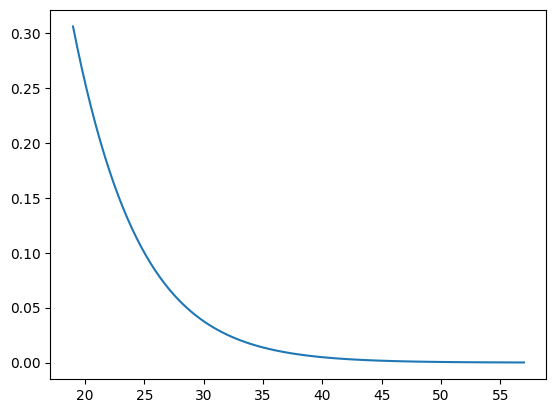

In [240]:
# Model parameters
β = 0.99
α = 0.36
δ = 0.025
σ = 2.0
ϕ = 0.99

Kss = ((1/β-1+δ)/α)**(1/(α-1));
xmin = Kss*0.5;
xmax = Kss*1.5;

Iss = δ*Kss;
Imin = ϕ*Iss;
print(Kss, Iss)

σ_z = 0.01
ρ_z = 0.9
σ_e_z = σ_z/(1-ρ_z**2)**0.5

min_FB = lambda a,b: a+b-tf.sqrt(a**2+b**2)
layers = [
    tf.keras.layers.Normalization(axis=-1, input_dim=2, mean=0, variance=1, invert=False),
    tf.keras.layers.Dense(32, activation='leaky_relu',  bias_initializer='he_uniform'),
    tf.keras.layers.Dense(32, activation='leaky_relu',  bias_initializer='he_uniform'),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.linear)
]
perceptron = tf.keras.Sequential(layers)

def model(k:Vector,z:Vector)->Tuple[Vector,Vector]:
    s = tf.concat([i[:,None] for i in [k,z]], axis=1) # equivalent to np.column_stack
    x = perceptron(s)
    sh = tf.sigmoid(x[:,0])
    h = tf.exp(x[:,1])
    return (sh,h)

λ=1
xvec = np.linspace(xmin,xmax,100,dtype='float32').reshape(-1,)
zvec = np.linspace(-2*σ_e_z,2*σ_e_z,100,dtype='float32').reshape(-1,)
sh, h = model(xvec,zvec)
c = sh*(xvec**α+(1-δ)*xvec)
print(tf.shape(c),tf.shape(h))
plt.plot(xvec, c, label = 'c(k,z)')

In [241]:
def residuals(k:Vector, z:Vector, ez:Vector):
    # Equations: 
    # 1) Euler: u'(c) - h = βE[u'(c')(f'(k,z)+(1-δ)) - (1-δ)h']
    # 2) Budget: c+k' = f(k,z)
    # 3) Complimentary Slackness: h(k'-(1-δ)k-Imin)=0, k'-(1-δ)k-Imin>=0, h>=0
    
    # h_ is normalized multiplier: h_ = h/c^(-σ)
    # -> Euler: h_ = β * u'(c)^-1 * E[u'(c')(f'(k,z)+(1-δ)h_')]
    # h = 0 means h_ = 0, h = c^(-σ) means h_ = 1, 
        
    # sh is share of minimum in total investment: (I-Imin)/I = (k'-(1-δ)k-Imin)/I = sh ==> Inv = Imin/(1-sh)
    # sh = 0 means k'-(1-δ)k-Imin = 0, sh=1 means k'-(1-δ)k-Imin rises to infty
    # sh has to kept between 0 and 1
    
    # h(k'-(1-δ)k-Imin) = h_*sh = 0
    
    
    # h references to h_
    sh,h=model(k,tf.exp(z))  
    Inv = sh*(tf.exp(z)*k**α+(1-δ)*k)
    kp = Inv+(1-δ)*k
    c = tf.exp(z)*k**α-Inv
    zp = z*ρ_z+ez
    shp,hp=model(kp,tf.exp(zp))
    Invp = sh*(tf.exp(zp)*kp**α+(1-δ)*kp)
    kpp = Invp+(1-δ)*kp
    cp = tf.exp(zp)*kp**α-Invp
    
    R1 = min_FB(1-h,1-sh)
    R2 = 1- c**(σ)*β*((tf.exp(zp)*α*kp**(α-1)+(1-δ)-(1-δ)*hp)*cp**(-σ))-h
    return R1, R2

def J(n):
    z = tf.random.normal(shape=(n,), stddev=σ_e_z)
    k = tf.random.uniform(shape=(n,),minval=xmin,maxval=xmax)
    ez1 = tf.random.normal(shape=(n,), stddev=σ_z)
    ez2 = tf.random.normal(shape=(n,), stddev=σ_z)
    R1_e1,R2_e1 = residuals(k,z,ez1)
    R1_e2,R2_e2 = residuals(k,z,ez2)
    R_squared = R1_e1*R1_e2+R2_e1*R2_e2
    return tf.reduce_mean(R_squared)

n = 5000
v = J(n)
v.numpy()

96533530.0

In [242]:
θ = perceptron.trainable_variables
print(str(θ)[:1000])

[<tf.Variable 'dense_159/kernel:0' shape=(2, 32) dtype=float32, numpy=
array([[-0.18306093,  0.07277083, -0.31214738,  0.33741572, -0.37876013,
         0.3505896 ,  0.24582979,  0.36066517,  0.11309037, -0.30825734,
        -0.20705968, -0.33515537, -0.2365783 , -0.08075705, -0.08543673,
         0.17312226, -0.10338786, -0.29915535, -0.28949153, -0.2742474 ,
         0.31590483, -0.34237903,  0.14748475,  0.18314674, -0.39728525,
        -0.17210208, -0.2119641 , -0.4053442 , -0.12007213, -0.13160348,
        -0.1089409 ,  0.29374716],
       [ 0.24617985, -0.11513495, -0.07114199, -0.31195578, -0.17853309,
         0.02053836, -0.22276512, -0.05752471, -0.31307763, -0.03662819,
        -0.2692786 , -0.02625033, -0.40240163,  0.33906004, -0.2997556 ,
         0.2381961 ,  0.15965459,  0.14406118,  0.36887315,  0.02646959,
        -0.00895593,  0.20705965,  0.39075932, -0.19573064,  0.23893127,
        -0.19111817,  0.0482702 , -0.1335454 , -0.0532777 ,  0.18188187,
         0.1296314

In [243]:
from tensorflow.keras.optimizers import Adam, SGD
variables = perceptron.trainable_variables
optimizer = Adam()
optimizer.lr.assign(0.001)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.001>

In [244]:
@tf.function
def training_step():
    
    with tf.GradientTape() as tape:
        xx = J(n)
        
    grads = tape.gradient(xx,θ)
    optimizer.apply_gradients(zip(grads,θ))
    return xx

def train_me(K):
    vals=[]
    for k in tqdm(tf.range(K)):
        val=training_step()
        vals.append(val.numpy())
    return vals

In [245]:
results = train_me(500)

100%|███████████████████████████████████████████████████████| 500/500 [00:09<00:00, 51.23it/s]


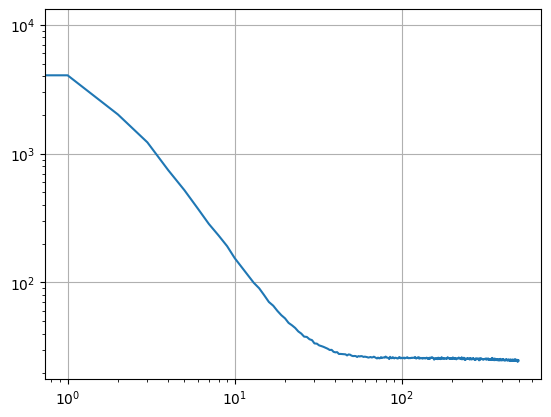

In [246]:
plt.plot(np.sqrt(results))
plt.xscale('log')
plt.yscale('log')
plt.grid()

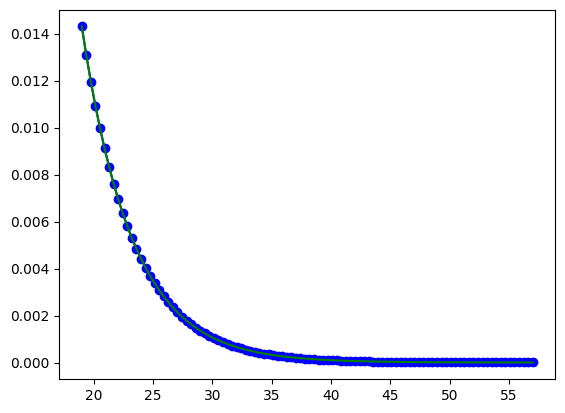

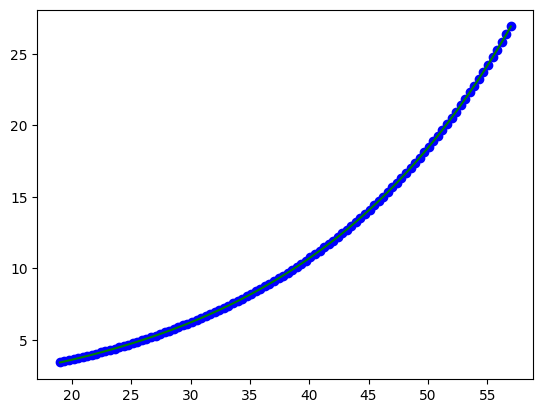

In [247]:
sh1, h1 = model(xvec, zvec*0+2*σ_e_z)
sh2, h2 = model(xvec, zvec*0-2*σ_e_z)
plt.figure(1)
plt.plot(xvec,sh1,label='Solved sh1',c='b', marker ='o')
plt.plot(xvec,sh1,label='Solved c(k,2σ_e_z)',c='g')

plt.figure(2)
plt.plot(xvec,h1,label='Solved c(k,2σ_e_z)',c='b', marker ='o')
plt.plot(xvec,h1,label='Solved c(k,2σ_e_z)',c='g')
